# Machine Learning: Regression

•	Regression
•	Beispiel: Tankanzeige
•	Selbst implementieren
•	Alternativ lineare Regression (scipy)
•	Zuverlässigkeit: PearsonR


## Regressionsanalyse des Heise Newstickers

### Lineare Regression mit `scipy`

Im letzten Teil hast du schon Statistik-Informationen zum Heise-Newsticker betrachtet. Nun arbeitest du wieder mit den gleichen Daten und führst eine Regressionanalyse durch.

Du weißt schon, wie du die Daten mit `pandas` einlesen kannst:

In [1]:
import pandas as pd
heise_monthly = pd.read_csv("heise-monthly.csv", parse_dates=["month"], index_col="month")

Vergegenwärtige dir nochmal die Zeitentwicklung:

<AxesSubplot:xlabel='month'>

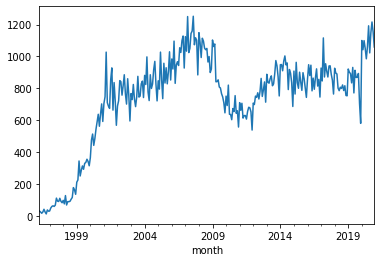

In [2]:
heise_monthly["count"].plot()

Nun verwendest du `scipy`, um die Daten mittels [linearer Regression](https://de.wikipedia.org/wiki/Lineare_Regression) zu fitten:

In [3]:
from scipy.stats import linregress
lrc = linregress(range(len(heise_monthly)), heise_monthly["count"].values)
lrc

LinregressResult(slope=2.232746932411362, intercept=407.54671999638447, rvalue=0.6464217963001598, pvalue=1.5687486526887305e-36, stderr=0.1534354804820437, intercept_stderr=26.24359788349783)

Das Pearson-R sagt die, wie "stark" der Zusammenhang ist und der *p-Wert*, wie verlässlich der Fit ist. Dazu sollte dieser möglichst klein sein, was hier schon ganz gut klappt.

Integriere nun die Regressionsgerade noch in den `DataFrame`:

In [4]:
heise_monthly["predict_count"] = [i*lrc.slope+lrc.intercept for i in range(len(heise_monthly))]

Und lass dir das Ergebnis grafisch ausgeben:

<AxesSubplot:xlabel='month'>

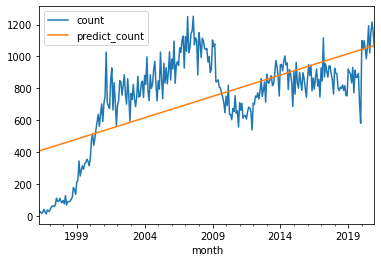

In [5]:
heise_monthly[["count", "predict_count"]].plot()

Das sieht ganz gut aus.

Betrachte zum Vergleich noch die Länge der Artikel:

In [6]:
lrt = linregress(range(len(heise_monthly)), heise_monthly["tokens"].values)
lrt

LinregressResult(slope=1.114943755543448, intercept=174.58440266261653, rvalue=0.9491280646742258, pvalue=4.427657231615895e-150, stderr=0.021536565865836597, intercept_stderr=3.683613285524433)

Du siehst, dass sowohl das Pearson-R näher an 1 liegt als auch der *p-Wert* viel kleiner ist. Der Fit ist also besser.

In [7]:
heise_monthly["predict_tokens"] = [i*lrt.slope+lrt.intercept for i in range(len(heise_monthly))]

<AxesSubplot:xlabel='month'>

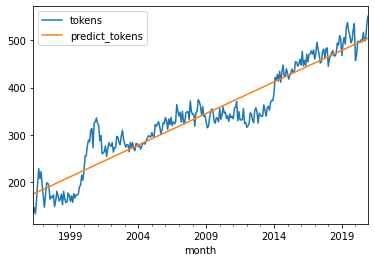

In [8]:
heise_monthly[["tokens", "predict_tokens"]].plot()

Wie du schon vermutet hast, ist die Approximation besser. Dennoch vermisst du einiges, z.B. ein Fehlerkorridor. Außerdem sind mögliche saisonale Effekte nicht berücksichtigt. Dazu reicht dir eine lineare Regression nicht aus.

`scikit-learn` bietet dir hier viel mehr Möglichkeiten, die du dir nun anschaust:

### Lineare Regression mit `scikit-learn`

In [28]:
from sklearn import linear_model
slrt = linear_model.LinearRegression()
X = [[i] for i in range(len(heise_monthly))]
Y = heise_monthly["tokens"].values
slrt.fit(X, Y)

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [25]:
heise_monthly["predict_tokens_sklearn_linear"] = slrt.predict(X)

<AxesSubplot:xlabel='month'>

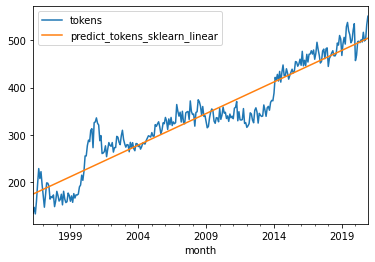

In [26]:
heise_monthly[["tokens", "predict_tokens_sklearn_linear"]].plot()

In [61]:
from sklearn.metrics import mean_squared_error, r2_score
def print_scores(ground_truth, predict):
    print('Mittlerer quadratischer Fehler', mean_squared_error(ground_truth, predict))
    # 1 entspricht einer 100% Vorhersage
    print('Coefficient of determination: %.2f' % r2_score(ground_truth, predict))
    
print_scores(Y, heise_monthly["predict_tokens_sklearn_linear"])

Mittlerer quadratischer Fehler 1063.5790076772098
Coefficient of determination: 0.90


Allerdings ist der Fehler jetzt in den *Trainingdaten* berechnet. Wenn du Machine Learning betreibst, interessiert du dich für *Vorhersagen* von unbekannten Werten. Deswegen wendest du jetzt einen Trick an und teilst die Datenmenge (mit den bekannten Werten) in zwei Teilmengen auf, eine *Trainingsdatenmenge* und eine *Testdatenmenge*. 

Der `fit`-Funktion gibst du nur die Trainingsdaten, die Vorhersage lässt du für die Testdaten durchführen. Da du dich für Vorhersagen *zukünftiger Daten* interessierst, nutzt du als Trainingsdaten die alten Werte, die Testdaten sind die neueren:

In [51]:
(X_train, X_test) = (X[:-50], X[-50:])
(Y_train, Y_test) = (Y[:-50], Y[-50:])
slrt.fit(X_train, Y_train)

LinearRegression()

In [65]:
print_scores(Y_test, slrt.predict(X_test))

Mittlerer quadratischer Fehler 1006.2815150013834
Coefficient of determination: -0.72


In [52]:
heise_monthly["predict_tokens_sklearn_linear"] = slrt.predict(X)

<AxesSubplot:xlabel='month'>

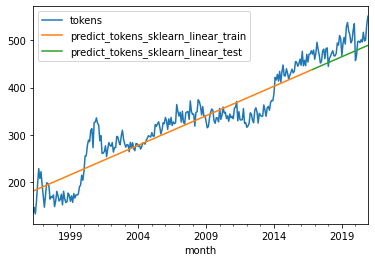

In [74]:
heise_monthly["predict_tokens_sklearn_linear_train"] = list(slrt.predict(X_train)) + [None]*len(X_test)
heise_monthly["predict_tokens_sklearn_linear_test"] = [None]*len(X_train) + list(slrt.predict(X_test))
heise_monthly[["tokens", "predict_tokens_sklearn_linear_train", "predict_tokens_sklearn_linear_test"]].plot()

In [69]:
from sklearn.tree import DecisionTreeRegressor

dtt = DecisionTreeRegressor(max_depth=4)

dtt.fit(X_train, Y_train)
print_scores(Y_test, dtt.predict(X_test))

Mittlerer quadratischer Fehler 852.6866071181357
Coefficient of determination: -0.46


<AxesSubplot:xlabel='month'>

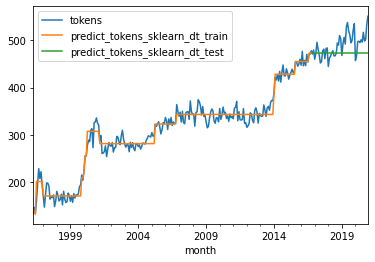

In [70]:
heise_monthly["predict_tokens_sklearn_dt_train"] = list(dtt.predict(X_train)) + [None]*len(X_test)
heise_monthly["predict_tokens_sklearn_dt_test"] = [None]*len(X_train) + list(dtt.predict(X_test))
heise_monthly[["tokens", "predict_tokens_sklearn_dt_train", "predict_tokens_sklearn_dt_test"]].plot()

In [72]:
from sklearn.ensemble import AdaBoostRegressor

abt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=42)

abt.fit(X_train, Y_train)
print_scores(Y_test, abt.predict(X_test))

Mittlerer quadratischer Fehler 1335.8880402341715
Coefficient of determination: -1.28


<AxesSubplot:xlabel='month'>

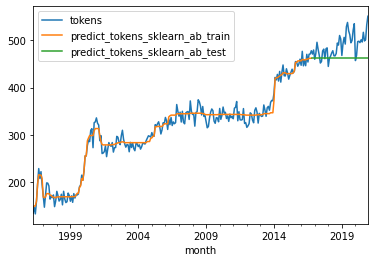

In [73]:
heise_monthly["predict_tokens_sklearn_ab_train"] = list(abt.predict(X_train)) + [None]*len(X_test)
heise_monthly["predict_tokens_sklearn_ab_test"] = [None]*len(X_train) + list(abt.predict(X_test))
heise_monthly[["tokens", "predict_tokens_sklearn_ab_train", "predict_tokens_sklearn_ab_test"]].plot()

In [75]:
from sklearn import ensemble
gbt = ensemble.GradientBoostingRegressor()
gbt.fit(X_train, Y_train)
print_scores(Y_test, gbt.predict(X_test))

Mittlerer quadratischer Fehler 806.7288330590189
Coefficient of determination: -0.38


<AxesSubplot:xlabel='month'>

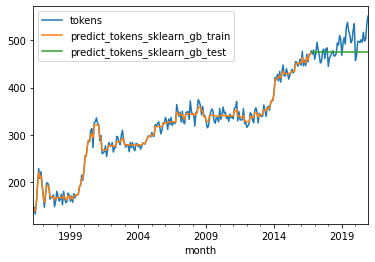

In [76]:
heise_monthly["predict_tokens_sklearn_gb_train"] = list(gbt.predict(X_train)) + [None]*len(X_test)
heise_monthly["predict_tokens_sklearn_gb_test"] = [None]*len(X_train) + list(gbt.predict(X_test))
heise_monthly[["tokens", "predict_tokens_sklearn_gb_train", "predict_tokens_sklearn_gb_test"]].plot()

In [79]:
from xgboost import XGBRegressor

In [94]:
import numpy as np
np.array(X_train).flatten()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [104]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
gbm = XGBRegressor()
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(np.array(X_train), np.array(Y_train))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [105]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 4,
 'min_child_weight': 1.0,
 'n_estimators': 500}

In [107]:
gbm = XGBRegressor(**reg_cv.best_params_)
gbm.fit(np.array(X_train), np.array(Y_train))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [110]:
gbm.predict(np.array(X_train))

array([133.85013, 146.28482, 132.59781, 159.3399 , 195.82803, 228.37854,
       207.64088, 221.84753, 194.15396, 170.04744, 146.90157, 172.93837,
       198.08566, 197.6443 , 191.65349, 163.98926, 169.05893, 167.0274 ,
       172.45775, 148.18127, 159.95988, 180.113  , 171.52267, 159.99649,
       162.88121, 173.91461, 151.93091, 180.25223, 164.28738, 156.7435 ,
       158.4349 , 176.37373, 171.44308, 159.6371 , 170.42264, 157.43195,
       175.08977, 166.50952, 172.72507, 172.5462 , 174.75691, 189.78162,
       193.37234, 214.57907, 203.99802, 222.7229 , 255.19757, 255.19757,
       277.58853, 288.4818 , 285.938  , 309.74536, 312.81955, 273.09302,
       325.9232 , 327.37057, 335.49756, 324.72595, 320.61075, 287.9979 ,
       297.9239 , 260.70712, 261.38644, 264.4948 , 276.42917, 254.23647,
       269.8034 , 283.23358, 277.76376, 276.03708, 283.29242, 263.91772,
       272.80026, 273.14594, 296.5675 , 294.92017, 284.36682, 279.68765,
       298.06525, 309.1967 , 290.5144 , 280.89026, 

In [111]:
gbm.predict(np.array(X_test))

array([478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151, 478.1151, 478.1151, 478.1151, 478.1151,
       478.1151, 478.1151], dtype=float32)

In [114]:
gbm.score(np.array(X_test), np.array(Y_test))

-0.22807232903541297

In [98]:
model = XGBRegressor(
    max_depth=5,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    np.array(X_train), 
    np.array(Y_train), 
    eval_metric="rmse", 
    eval_set=[(np.array(X_train), np.array(Y_train)), 
              (np.array(X_test), np.array(Y_test))], 
    verbose=True, 
    early_stopping_rounds = 10
)

[0]	validation_0-rmse:319.21957	validation_1-rmse:489.77332
[1]	validation_0-rmse:319.21954	validation_1-rmse:489.77328
[2]	validation_0-rmse:319.21954	validation_1-rmse:489.77328
[3]	validation_0-rmse:319.21957	validation_1-rmse:489.77328
[4]	validation_0-rmse:319.21957	validation_1-rmse:489.77328
[5]	validation_0-rmse:319.21957	validation_1-rmse:489.77328
[6]	validation_0-rmse:319.21954	validation_1-rmse:489.77328
[7]	validation_0-rmse:319.21954	validation_1-rmse:489.77328
[8]	validation_0-rmse:319.21954	validation_1-rmse:489.77328
[9]	validation_0-rmse:319.21954	validation_1-rmse:489.77332
[10]	validation_0-rmse:319.21957	validation_1-rmse:489.77328


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [99]:
model.predict(np.array(X_train))

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

In [102]:
model.score(np.array(X_train), np.array(Y_train))

-14.449626203614498

## Bessere Vorhersage von zukünftigen Werten

Dafür gibt es spezielle Pakete wie [`prophet`](https://facebook.github.io/prophet/).

In [9]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Die Daten müssen dazu ein bisschen anders vorbereitet werden, du brauchst einen speziellen `DataFrame`:

In [10]:
pa = pd.DataFrame()
pa["ds"] = heise_monthly.index.values
pa["y"] = heise_monthly["tokens"].values
pa

,ds,y
0,1996-04-01,133.766667
1,1996-05-01,146.375000
2,1996-06-01,132.500000
3,1996-07-01,159.375000
4,1996-08-01,195.756098
...,...,...
292,2020-08-01,517.211350
293,2020-09-01,498.890244
294,2020-10-01,501.518914
295,2020-11-01,533.060606


Dann instanziierst du die `Prophet`-Klasse:

In [11]:
m = Prophet()
m.fit(pa)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Und erzeugst einen `DataFrame` für die zukünftigen Werte. Hier benötigst du eine *monatliche Frequenz*:

In [12]:
future = m.make_future_dataframe(periods=20, freq='M')

Jetzt kannst du die Vorhersage durchführen. `yhat` ist der wahrscheinlichste Wert, `Prophet` liefert dir auch noch einen *Korridor*:

In [13]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
312,2022-03-31,561.395324,528.332812,590.295812
313,2022-04-30,548.480014,516.406269,579.239087
314,2022-05-31,566.024580,535.181373,596.420738
315,2022-06-30,560.773752,528.655805,592.221273
316,2022-07-31,558.217120,525.821826,588.877297


Die Daten kannst du sehr einfach visualisieren und seihst, dass das Ergebnis besser ist als unsere einfach Regression oben:

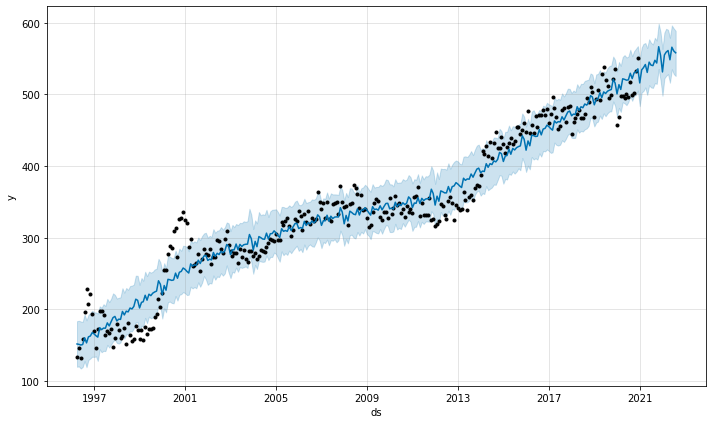

In [14]:
m.plot(forecast)

`Prophet` kann nocht mehr, wie etwa Langfristtrends oder saisonale Schwankungen berechnen:

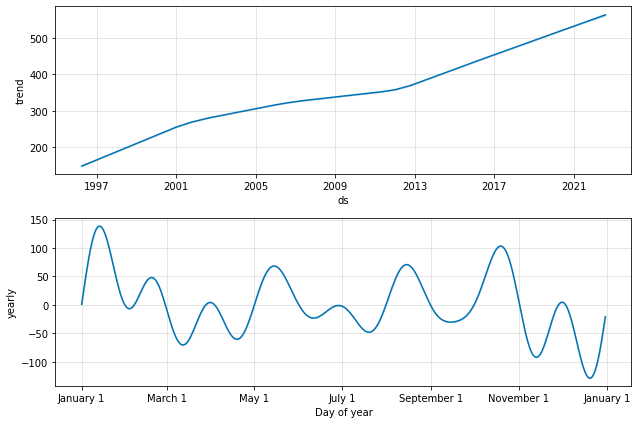

In [15]:
m.plot_components(forecast)

## Anspruchsvolle Regression

Wie du oben siehst, hat die lineare Regression gut funktioniert. Die weit fortschrittlicheren Verfahren haben hingegen nur konstante Werte für die Vorhersage geliefert und waren damit nicht sinnvoll einsetzbar.

Eigene Modelle musst du auf jeden Fall genau testen, bevor du sie einsetzt. Oft ist es daher günstig, wenn du ein schon existierendes Modell verwendest.